## Определение возраста покупателей

### Описание проекта

Сетевой супермаркет **«Хлеб-Соль»** внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
    
    -Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
    -Контролировать добросовестность кассиров при продаже алкоголя.
    
Наша задача построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
labels = pd.read_csv('YOUR_DATA')
print(f"Общее количество изображений: {labels.shape[0]}")

Общее количество изображений: 7591


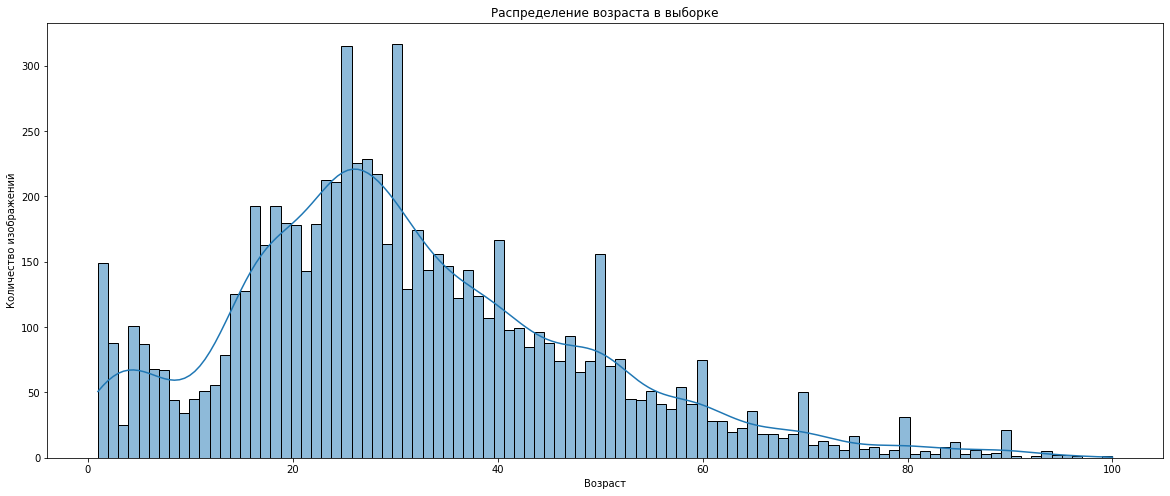

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64
--------------------------------------------------
Общее количество классов (уникальных возрастов): 97

Количество фотографий по возрастам:
30     317
25     315
27     229
26     226
28     217
      ... 
96       2
93       1
100      1
91       1
97       1
Name: real_age, Length: 97, dtype: int64


In [3]:
plt.figure(figsize=(20, 8))
sns.histplot(labels['real_age'], bins=100, kde=True)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.show()

print(labels['real_age'].describe())

age_counts = labels['real_age'].value_counts(ascending=False)

print("-"*50)
print(f"Общее количество классов (уникальных возрастов): {len(age_counts)}")
print("\nКоличество фотографий по возрастам:")
print(age_counts)

In [4]:
datagen = ImageDataGenerator(rescale=1./255)
generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw'
)

Found 7591 validated image filenames.


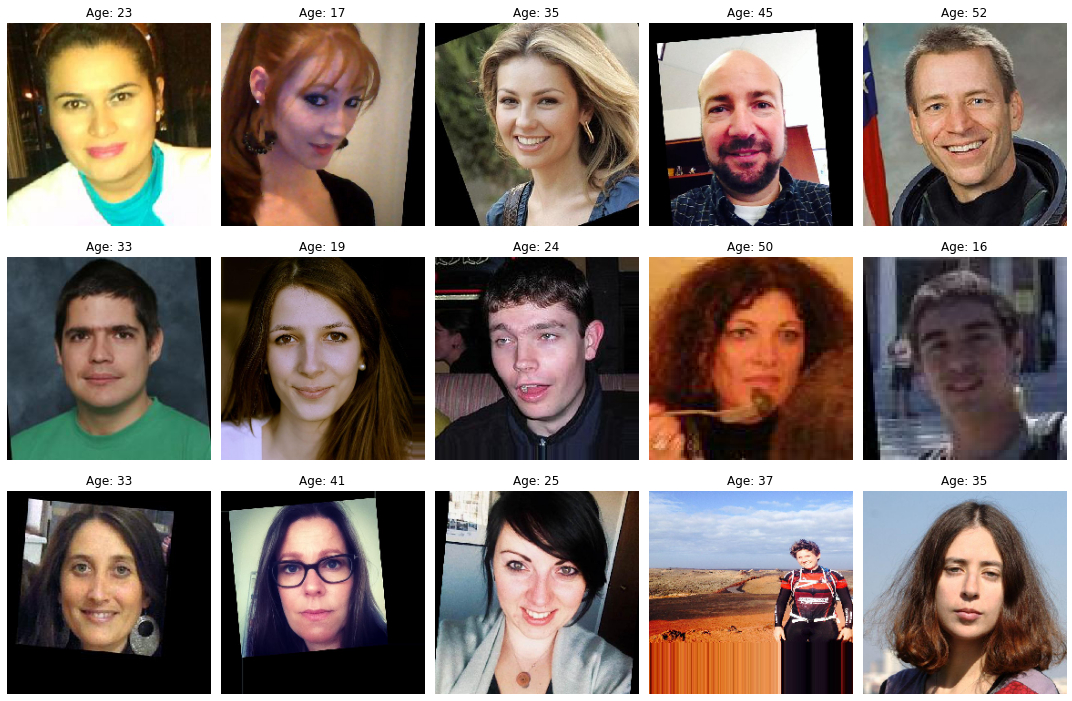

In [5]:
plt.figure(figsize=(15, 10))
images, ages = next(generator)
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(images[i])
    plt.title(f'Age: {int(ages[i])}')
    plt.axis('off')
plt.tight_layout()
plt.show()

    Всего в датасете 7591 изображений из которых 97 классов, этого вполне хватит для обучения модели. Минимальный возраст на фото 1 год, максимальный - 100 лет, чаще всего встречается возрастная группа людей 25-35 лет, средний возраст люедй на изображениях 31 год

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

def load_train(path):
    df = pd.read_csv(path + '/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2]
    )

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=0
    )

    return train_generator

def load_test(path):
    df = pd.read_csv(path + '/labels.csv')

    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=0
    )

    return test_generator

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    backbone.trainable = True

    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(512, activation='relu', kernel_regularizer='l2'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='mse',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=70,
steps_per_epoch=None, validation_steps=None):


    history = model.fit(
        train_data,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=test_data,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

```

```

Train for 190 steps, validate for 48 steps
Epoch 1/70
2025-06-16 13:15:47.109002: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-06-16 13:15:47.668933: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 107s - loss: 1192.2045 - mae: 31.5058 - val_loss: 1374.1034 - val_mae: 32.9036
Epoch 2/70
190/190 - 72s - loss: 1104.1476 - mae: 31.0896 - val_loss: 1239.1720 - val_mae: 30.8020
Epoch 3/70
190/190 - 70s - loss: 1057.2925 - mae: 30.5889 - val_loss: 1048.2914 - val_mae: 29.1039
Epoch 4/70
190/190 - 71s - loss: 1004.7597 - mae: 29.9401 - val_loss: 1482.7568 - val_mae: 36.4921
Epoch 5/70
190/190 - 69s - loss: 949.8465 - mae: 29.1309 - val_loss: 747.4987 - val_mae: 25.3037
Epoch 6/70
190/190 - 76s - loss: 881.8414 - mae: 28.0918 - val_loss: 735.5504 - val_mae: 25.3205
Epoch 7/70
190/190 - 78s - loss: 811.2838 - mae: 26.8546 - val_loss: 708.9105 - val_mae: 24.7386
Epoch 8/70
190/190 - 77s - loss: 731.4292 - mae: 25.3991 - val_loss: 582.1714 - val_mae: 22.1285
Epoch 9/70
190/190 - 78s - loss: 643.3766 - mae: 23.6751 - val_loss: 661.0275 - val_mae: 23.6629
Epoch 10/70
190/190 - 77s - loss: 557.4386 - mae: 21.8013 - val_loss: 432.6622 - val_mae: 18.4881
Epoch 11/70
190/190 - 78s - loss: 472.2158 - mae: 19.8202 - val_loss: 436.3660 - val_mae: 18.5385
Epoch 12/70
190/190 - 74s - loss: 389.4769 - mae: 17.6696 - val_loss: 279.1323 - val_mae: 13.7653
Epoch 13/70
190/190 - 76s - loss: 311.9178 - mae: 15.5793 - val_loss: 389.1955 - val_mae: 17.1629
Epoch 14/70
190/190 - 76s - loss: 248.0713 - mae: 13.5348 - val_loss: 197.5098 - val_mae: 10.9908
Epoch 15/70
190/190 - 76s - loss: 196.7063 - mae: 11.6585 - val_loss: 186.4658 - val_mae: 10.6822
Epoch 16/70
190/190 - 71s - loss: 156.4017 - mae: 10.0384 - val_loss: 182.0460 - val_mae: 10.4627
Epoch 17/70
190/190 - 72s - loss: 125.9143 - mae: 8.7296 - val_loss: 105.2377 - val_mae: 7.3600
Epoch 18/70
190/190 - 74s - loss: 100.9655 - mae: 7.6051 - val_loss: 99.4362 - val_mae: 7.1609
Epoch 19/70
190/190 - 74s - loss: 83.9955 - mae: 6.7687 - val_loss: 88.2490 - val_mae: 6.7719
Epoch 20/70
190/190 - 76s - loss: 74.9685 - mae: 6.3541 - val_loss: 99.5672 - val_mae: 7.1395
Epoch 21/70
190/190 - 76s - loss: 68.8288 - mae: 6.0241 - val_loss: 146.3313 - val_mae: 8.7459
Epoch 22/70
190/190 - 76s - loss: 64.5727 - mae: 5.8573 - val_loss: 109.7683 - val_mae: 7.8068
Epoch 23/70
190/190 - 71s - loss: 62.0104 - mae: 5.7459 - val_loss: 98.9959 - val_mae: 7.2530
Epoch 24/70
190/190 - 68s - loss: 61.1836 - mae: 5.6616 - val_loss: 92.7206 - val_mae: 7.0860
Epoch 25/70
190/190 - 68s - loss: 59.3736 - mae: 5.5962 - val_loss: 92.0626 - val_mae: 6.9162
Epoch 26/70
190/190 - 68s - loss: 58.3242 - mae: 5.5077 - val_loss: 84.7921 - val_mae: 6.7026
Epoch 27/70
190/190 - 68s - loss: 57.0855 - mae: 5.4864 - val_loss: 98.5446 - val_mae: 7.2618
Epoch 28/70
190/190 - 68s - loss: 55.2559 - mae: 5.4016 - val_loss: 97.2572 - val_mae: 7.1938
Epoch 29/70
190/190 - 68s - loss: 54.9828 - mae: 5.3762 - val_loss: 110.6030 - val_mae: 7.8175
Epoch 30/70
190/190 - 68s - loss: 69.9658 - mae: 6.0235 - val_loss: 115.0843 - val_mae: 7.8352
Epoch 31/70
190/190 - 68s - loss: 61.3732 - mae: 5.6876 - val_loss: 90.7024 - val_mae: 6.7815
Epoch 32/70
190/190 - 68s - loss: 56.4090 - mae: 5.4370 - val_loss: 90.4111 - val_mae: 6.7179
Epoch 33/70
190/190 - 68s - loss: 53.6881 - mae: 5.2986 - val_loss: 129.6499 - val_mae: 8.6729
Epoch 34/70
190/190 - 68s - loss: 50.8780 - mae: 5.1260 - val_loss: 81.4682 - val_mae: 6.4585
Epoch 35/70
190/190 - 68s - loss: 48.5206 - mae: 5.0344 - val_loss: 99.2960 - val_mae: 7.4110
Epoch 36/70
190/190 - 68s - loss: 51.2070 - mae: 5.1140 - val_loss: 90.9408 - val_mae: 6.8791
Epoch 37/70
190/190 - 68s - loss: 50.4818 - mae: 5.1018 - val_loss: 108.1082 - val_mae: 8.0517
Epoch 38/70
190/190 - 68s - loss: 47.0435 - mae: 4.9276 - val_loss: 83.2821 - val_mae: 6.5801
Epoch 39/70
190/190 - 68s - loss: 48.2408 - mae: 4.9772 - val_loss: 107.2124 - val_mae: 7.7275
Epoch 40/70
190/190 - 68s - loss: 46.3154 - mae: 4.8890 - val_loss: 79.7216 - val_mae: 6.5089
Epoch 41/70
190/190 - 68s - loss: 44.4237 - mae: 4.7203 - val_loss: 82.9861 - val_mae: 6.6193
Epoch 42/70
190/190 - 68s - loss: 46.5088 - mae: 4.8393 - val_loss: 89.5073 - val_mae: 6.6583
Epoch 43/70
190/190 - 68s - loss: 46.0773 - mae: 4.8749 - val_loss: 82.5588 - val_mae: 6.4237
Epoch 44/70
190/190 - 69s - loss: 46.3431 - mae: 4.8674 - val_loss: 117.6774 - val_mae: 8.0374
Epoch 45/70
190/190 - 70s - loss: 51.7822 - mae: 5.1228 - val_loss: 97.4857 - val_mae: 6.9790
Epoch 46/70
190/190 - 70s - loss: 49.1566 - mae: 5.0256 - val_loss: 87.9415 - val_mae: 6.6207
Epoch 47/70
190/190 - 70s - loss: 47.3975 - mae: 4.9330 - val_loss: 82.7166 - val_mae: 6.6580
Epoch 48/70
190/190 - 69s - loss: 44.0612 - mae: 4.7742 - val_loss: 87.5512 - val_mae: 6.7593
Epoch 49/70
190/190 - 70s - loss: 42.7027 - mae: 4.6553 - val_loss: 89.9261 - val_mae: 6.9750
Epoch 50/70
190/190 - 70s - loss: 41.5531 - mae: 4.5990 - val_loss: 85.8309 - val_mae: 6.6286
Epoch 51/70
190/190 - 70s - loss: 42.0757 - mae: 4.6135 - val_loss: 87.6354 - val_mae: 6.8137
Epoch 52/70
190/190 - 70s - loss: 41.4567 - mae: 4.6244 - val_loss: 89.0184 - val_mae: 6.8985
Epoch 53/70
190/190 - 69s - loss: 40.2598 - mae: 4.5334 - val_loss: 87.9684 - val_mae: 6.6677
Epoch 54/70
190/190 - 70s - loss: 39.9618 - mae: 4.5034 - val_loss: 92.1084 - val_mae: 7.2169
Epoch 55/70
190/190 - 70s - loss: 41.5794 - mae: 4.6180 - val_loss: 89.8634 - val_mae: 6.9069
Epoch 56/70
190/190 - 70s - loss: 53.1127 - mae: 5.1437 - val_loss: 154.6767 - val_mae: 9.2804
Epoch 57/70
190/190 - 70s - loss: 65.6574 - mae: 5.7579 - val_loss: 95.8821 - val_mae: 7.2887
Epoch 58/70
190/190 - 70s - loss: 43.9417 - mae: 4.7871 - val_loss: 89.0891 - val_mae: 6.7787
Epoch 59/70
190/190 - 70s - loss: 41.5889 - mae: 4.6099 - val_loss: 80.5235 - val_mae: 6.4344
Epoch 60/70
190/190 - 69s - loss: 40.2932 - mae: 4.5649 - val_loss: 88.5540 - val_mae: 6.7915
Epoch 61/70
190/190 - 70s - loss: 38.8406 - mae: 4.4349 - val_loss: 84.0714 - val_mae: 6.6420
Epoch 62/70
190/190 - 69s - loss: 37.6431 - mae: 4.3597 - val_loss: 86.1181 - val_mae: 6.7930
Epoch 63/70
190/190 - 68s - loss: 37.6624 - mae: 4.3601 - val_loss: 89.2409 - val_mae: 6.9846
Epoch 64/70
190/190 - 68s - loss: 37.4915 - mae: 4.3574 - val_loss: 91.7475 - val_mae: 7.0609
Epoch 65/70
190/190 - 68s - loss: 36.9659 - mae: 4.2990 - val_loss: 80.0786 - val_mae: 6.3907
Epoch 66/70
190/190 - 68s - loss: 36.0776 - mae: 4.2424 - val_loss: 77.0908 - val_mae: 6.3142
Epoch 67/70
190/190 - 68s - loss: 36.8172 - mae: 4.3121 - val_loss: 80.8033 - val_mae: 6.4730
Epoch 68/70
190/190 - 68s - loss: 37.1398 - mae: 4.3652 - val_loss: 79.5322 - val_mae: 6.4825
Epoch 69/70
190/190 - 68s - loss: 36.5206 - mae: 4.2948 - val_loss: 78.0879 - val_mae: 6.3548
Epoch 70/70
190/190 - 68s - loss: 36.6317 - mae: 4.3356 - val_loss: 108.2443 - val_mae: 7.4752

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 7s - loss: 108.2443 - mae: 7.4752
Test MAE: 7.4752

```

## Анализ обученной модели

    В ходе выполнения проекта мы использовали датасет с 7591 изображением в котором 97 классов, средний возраст на изображених 31 год, чаще всего встречается возрастная группа от 25 до 35 лет.

    За основу модели была взята архитектура ResNet50 с двумя дополнительными слоями с батч нормализацией и дропаутом для регулирования переобучения. Модель достигла высокого качества, также имеет достаточно высокую скорость обучения (~70 секунд на эпоху).

    Перед обучением данные были обработаны, была добавлена аугментация (повороты, сдвиги, изменение яркости), также есть разделение на выборки 80% данных на обучение модели и 20% на валидацию.

    Итоговая метрика MAE получилась 7.4752, что соответствует условиям задачи, во время обучения был результат лучше - 6.3142. Результаты модели можно улучшить, например, использовать более современные подходы или улучшенные версии использованной архитектуры, также спустя некоторое время работы(3-6 месяцев) можно дообучить модель на собранных данных.